In [2]:
# initialized connection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2 as pg

In [81]:
# read pwd string from save file
with open('postgrest_pwd.txt', 'r') as f:
    pwd = f.readline()

In [82]:
# read data from table to datatframe with Month form 201801
table = 'mat_view_cc_kpi_m'
with pg.connect(database='ktc', user='postgres', password=pwd) as con:
    df = pd.read_sql('select * from ' + table + ' where "Month"::bigint >= 201801', con = con)
    con.close()

## Oss Credit card by month
### Approved performance

#### Finalized

In [119]:
df_gr = df.groupby(['Month', 'channel', 'channel_sub'])
df_gr['finalized'].sum().unstack(0).applymap("{:,d}".format)

Month                201801  201802  201803  201804
channel channel_sub                                
OSS     Direct       17,962  21,490  21,146  16,711
        OSS_Tele      1,184   1,275   1,158   1,495
Tele    Telesales     3,677   4,752   5,913   4,476

#### Approve-new

In [120]:
df_gr['appr_new'].sum().unstack(0).applymap("{:,d}".format)

Month               201801 201802 201803 201804
channel channel_sub                            
OSS     Direct       6,694  8,017  7,741  6,099
        OSS_Tele       530    496    459    607
Tele    Telesales    1,472  1,544  1,931  1,539

#### % Appr-rate

In [141]:
(df_gr['appr_new'].sum()/df_gr['finalized'].sum()).unstack(0).applymap("{:.0%}".format)

Month               201801 201802 201803 201804
channel channel_sub                            
OSS     Direct         37%    37%    37%    36%
        OSS_Tele       45%    39%    40%    41%
Tele    Telesales      40%    32%    33%    34%

#### Credit limit new

In [138]:
(df_gr['credit_limit_new'].sum()/df_gr['appr_new'].sum()).unstack(0).applymap("{:,.0f}".format)

Month                201801  201802  201803  201804
channel channel_sub                                
OSS     Direct       51,229  53,753  46,022  53,392
        OSS_Tele     54,630  43,952  40,033  36,219
Tele    Telesales    52,739  52,141  50,016  46,648

#### % active60D

In [134]:
(df_gr['active60'].sum()/df_gr['appr_new'].sum()).unstack(0).applymap("{:.0%}".format)

Month               201801 201802 201803 201804
channel channel_sub                            
OSS     Direct         61%    62%    55%    23%
        OSS_Tele       71%    75%    65%    31%
Tele    Telesales      86%    86%    81%    37%

In [137]:
(df_gr['active60'].sum()/df_gr['appr_new'].sum()).unstack(0).applymap("{:.0%}".format)

Month               201801 201802 201803 201804
channel channel_sub                            
OSS     Direct         61%    62%    55%    23%
        OSS_Tele       71%    75%    65%    31%
Tele    Telesales      86%    86%    81%    37%

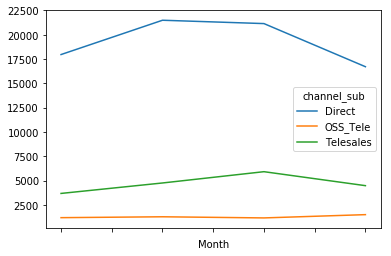

In [235]:
df.groupby(['channel_sub', 'Month'])['finalized'].sum().unstack(0).plot()

In [251]:
df_gr[['finalized', 'appr_new']].sum().stack().unstack(0).applymap("{:,d}".format)

Month                          201801  201802  201803  201804
channel channel_sub                                          
OSS     Direct      finalized  17,962  21,490  21,146  16,711
                    appr_new    6,694   8,017   7,741   6,099
        OSS_Tele    finalized   1,184   1,275   1,158   1,495
                    appr_new      530     496     459     607
Tele    Telesales   finalized   3,677   4,752   5,913   4,476
                    appr_new    1,472   1,544   1,931   1,539

In [274]:
i = df_gr[['finalized', 'appr_new']].sum().stack()

In [277]:
i.index.names = ['Month','channel','channel_sub','kpi']

In [278]:
i

Month   channel  channel_sub  kpi      
201801  OSS      Direct       finalized    17962
                              appr_new      6694
                 OSS_Tele     finalized     1184
                              appr_new       530
        Tele     Telesales    finalized     3677
                              appr_new      1472
201802  OSS      Direct       finalized    21490
                              appr_new      8017
                 OSS_Tele     finalized     1275
                              appr_new       496
        Tele     Telesales    finalized     4752
                              appr_new      1544
201803  OSS      Direct       finalized    21146
                              appr_new      7741
                 OSS_Tele     finalized     1158
                              appr_new       459
        Tele     Telesales    finalized     5913
                              appr_new      1931
201804  OSS      Direct       finalized    16711
                             